In [33]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.layers import Input, Dense

# Generic Fucntions

In [2]:
labels=pickle.load( open('labels.pkl', 'rb'))
features=pickle.load( open('features.pkl', 'rb'))
features_tfidf= pickle.load( open('features_tfidf.pkl', 'rb'))
word_tfidf_weights=pickle.load( open('word_tfidf_weights.pkl', 'rb'))
non_text_features_np = features.drop(columns=['title', 'text', 'combined_text', 'label']).to_numpy()

In [3]:
def get_metrics(clf,test_ft,test_labels):
    pred_labels=clf.predict(test_ft)
    print(classification_report(pred_labels,test_labels,target_names=["fake","real"]))

In [4]:
def plot_ROC(test):
    
    pred_labels=clf.predict(test_ft)
    fpr, tpr, thresholds = roc_curve(test,pred_labels)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
    

In [7]:
class ANN_model(tf.keras.models.Model):
    def __init__(self):
        super(ANN_model,self).__init__()
        self.layer1= Dense(64, activation="relu")
        self.layer2= Dense(32,activation="relu")
        self.label= Dense(1,activation="sigmoid")
        
    def call(self,inputs):
        x=self.layer1(inputs)
        x=self.layer2(x)
        x=self.label(x)
        
        return x

In [8]:
def plot_loss_acc(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [10]:
def split_data_ml(features,labels):
    
    scaler=StandardScaler()
    norm_features=scaler.fit_transform(features_tfidf)
    train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
    print("----------------Train data------------------------\n")
    print(f" train data features shape {train_ft.shape} \n train data labels shape {train_labels.shape}\n")
    print("-----------------Test data-------------------------\n")
    print(f" test data features shape {test_ft.shape} \n test data labels shape {test_labels.shape}")
    
    return train_ft,test_ft,train_labels,test_labels


In [30]:
def split_data_dl(features,labels):
    
    train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

    print("Training set shape:", X_train.shape)
    print("Validation set shape:", X_val.shape)
    print("Test set shape:", test_ft.shape)
    
    return X_train,y_train,X_val,y_val,test_ft,test_labels

# 1.  TF-IDF vectors + text characteristics 

## Machine Learning models

In [21]:
features_tfidf_txt = np.hstack((features_tfidf, non_text_features_np))

In [46]:
pickle.dump(features_tfidf_txt, open('features_tfidf_txt.pkl', 'wb'))
features_tfidf_txt = pickle.load( open('features_tfidf_txt.pkl', 'rb'))

### Logistic Regression

In [22]:
train_ft,test_ft,train_labels,test_labels=split_data_ml(features_tfidf_txt,labels)

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


In [23]:
log_clf = LogisticRegression(random_state=0).fit(train_ft, train_labels)

In [24]:
get_metrics(log_clf,test_ft,test_labels)

              precision    recall  f1-score   support

        fake       0.90      0.93      0.91      6762
        real       0.93      0.91      0.92      7546

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



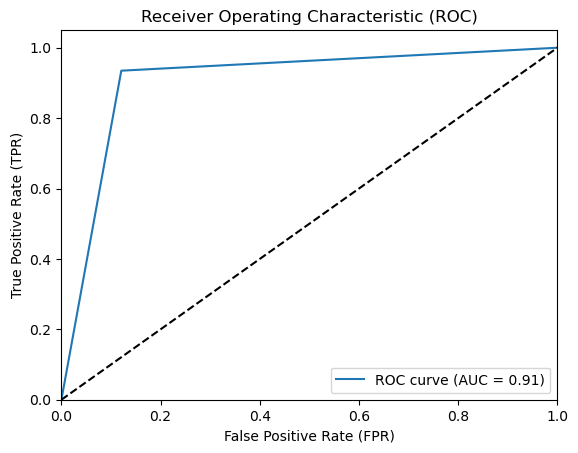

In [25]:
plot_ROC(test_labels)

### Linear Discriminant Analysis

In [26]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)

In [27]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

        fake       0.88      0.93      0.90      6580
        real       0.94      0.89      0.91      7728

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308



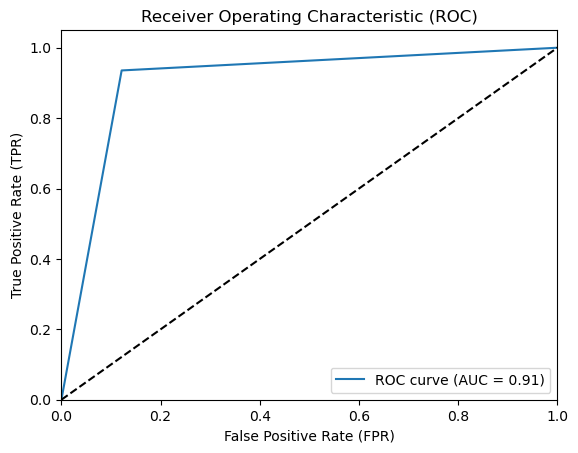

In [28]:
plot_ROC(test_labels)

### Artificial Neural network 

In [31]:
x_train,y_train,X_val,y_val,test_ft,test_labels=split_data_dl(features_tfidf_txt,labels)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [34]:
tfidf_txt_model= ANN_model()
tfidf_txt_model.build((None,115))
print(tfidf_txt_model.summary())

Model: "ann_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  7424      
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
tfidf_txt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=tfidf_txt_model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 11s 3ms/step - loss: 0.2182 - accuracy: 0.9103 - val_loss: 0.1632 - val_accuracy: 0.9352
Epoch 2/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1603 - accuracy: 0.9354 - val_loss: 0.1419 - val_accuracy: 0.9432
Epoch 3/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1435 - accuracy: 0.9426 - val_loss: 0.1259 - val_accuracy: 0.9519
Epoch 4/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.1301 - accuracy: 0.9485 - val_loss: 0.1188 - val_accuracy: 0.9520
Epoch 5/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1185 - accuracy: 0.9541 - val_loss: 0.1096 - val_accuracy: 0.9569
Epoch 6/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1099 - accuracy: 0.9573 - val_loss: 0.1015 - val_accuracy: 0.9616
Epoch 7/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1015 - accuracy: 0.9603 - val_loss: 0.0973 - val_accuracy

In [38]:
# Evaluate the model on the test set
test_loss, test_accuracy = tfidf_txt_model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 2ms/step - loss: 0.0924 - accuracy: 0.9683
Test Loss: 0.09243853390216827, Test Accuracy: 0.9683393836021423


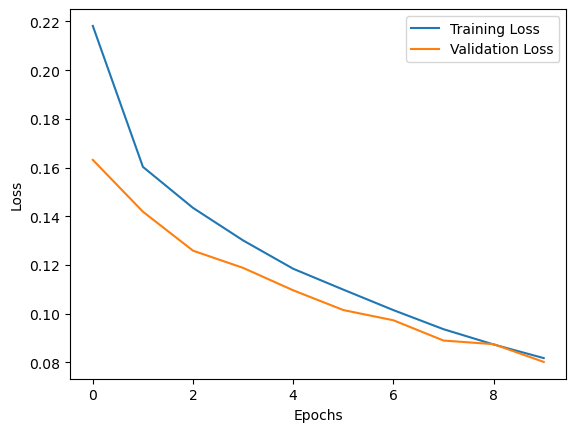

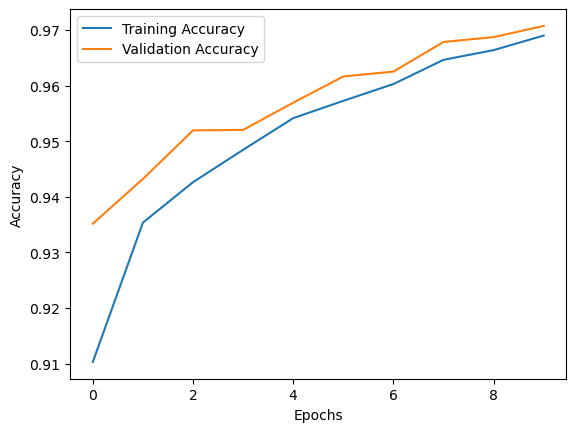

In [39]:
plot_loss_acc(history)

In [100]:
tfidf_txt_model.save_weights("tfidf_txt_model.h5")

# 2. Word2vec vectors + text characteristics 

# Machine Learning Models

In [40]:
doc=list(features["combined_text"])

In [41]:
def tokenize_words(text):
    tokenized_words,vocab=[],[]
    for i in text:
        tokenizer = RegexpTokenizer(r'\w+')     #using regular expression tokenizer
        wrd_token=tokenizer.tokenize(i)         
        tokenized_words.append(wrd_token)
        vocab.extend(wrd_token)
    return tokenized_words, vocab


doc_tokens_w2v,vocab=tokenize_words(doc)  #tokenizing the doc(ans+que)

In [42]:
model_doc=Word2Vec(doc_tokens_w2v,min_count=2,window=4) 

In [43]:
sentence_vectors = []
for sentence in doc:
    tokens = word_tokenize(sentence.lower())
    sentence_vector = np.zeros(model_doc.vector_size)
    if len(tokens)==0:
        sentence_vectors.append([0]*100)
    else:
        for token in tokens:
            if token in model_doc.wv:
                token_vector = model_doc.wv[token]
                sentence_vector += token_vector
        sentence_vector /= len(tokens)
        sentence_vectors.append(sentence_vector)

# Convert the list of sentence vectors to a NumPy array
sentence_vectors = np.array(sentence_vectors)

In [44]:
features_w2v_txt = np.hstack((sentence_vectors, non_text_features_np))

In [47]:
pickle.dump(features_w2v, open('features_w2v_txt.pkl', 'wb'))

In [48]:
features_w2v_txt = pickle.load( open('features_w2v_txt.pkl', 'rb'))

In [49]:
train_ft,test_ft,train_labels,test_labels=split_data_ml(features_w2v_txt,labels)

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


### Logistic Regression

              precision    recall  f1-score   support

        fake       0.91      0.92      0.91      6897
        real       0.93      0.91      0.92      7411

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



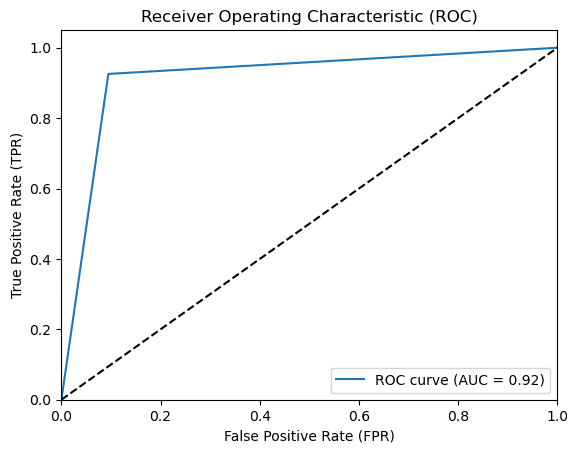

In [50]:
clf = LogisticRegression(random_state=0).fit(train_ft, train_labels)
get_metrics(clf,test_ft,test_labels)
plot_ROC(test_labels)

In [51]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

        fake       0.91      0.92      0.91      6897
        real       0.93      0.91      0.92      7411

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



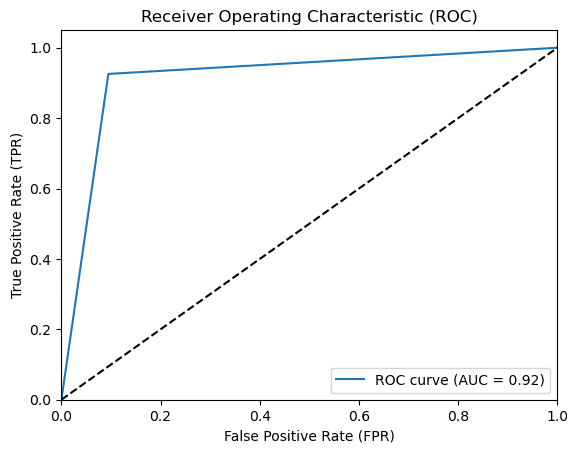

In [52]:
plot_ROC(test_labels)

### Linear Discriminant Analysis

In [53]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)

In [54]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

        fake       0.88      0.92      0.90      6741
        real       0.93      0.89      0.91      7567

    accuracy                           0.91     14308
   macro avg       0.90      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308



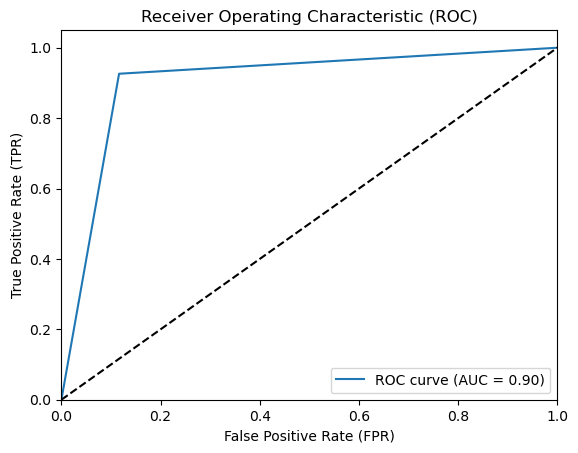

In [55]:
plot_ROC(test_labels)

### Artificial Neural Network

In [56]:
x_train,y_train,X_val,y_val,test_ft,test_labels=split_data_dl(features_w2v_txt,labels)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [57]:
tfidf_w2v_model= ANN_model()
tfidf_w2v_model.build((None,115))
print(tfidf_w2v_model.summary())

Model: "ann_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  7424      
                                                                 
 dense_4 (Dense)             multiple                  2080      
                                                                 
 dense_5 (Dense)             multiple                  33        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
tfidf_w2v_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=tfidf_w2v_model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.2207 - accuracy: 0.9081 - val_loss: 0.1626 - val_accuracy: 0.9355
Epoch 2/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1591 - accuracy: 0.9368 - val_loss: 0.1464 - val_accuracy: 0.9393
Epoch 3/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.1415 - accuracy: 0.9429 - val_loss: 0.1313 - val_accuracy: 0.9472
Epoch 4/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.1284 - accuracy: 0.9493 - val_loss: 0.1191 - val_accuracy: 0.9540
Epoch 5/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1188 - accuracy: 0.9535 - val_loss: 0.1127 - val_accuracy: 0.9553
Epoch 6/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1096 - accuracy: 0.9575 - val_loss: 0.1087 - val_accuracy: 0.9597
Epoch 7/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1011 - accuracy: 0.9612 - val_loss: 0.1018 - val_accuracy:

In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy = tfidf_w2v_model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 2ms/step - loss: 0.0943 - accuracy: 0.9678
Test Loss: 0.09433166682720184, Test Accuracy: 0.9677802920341492


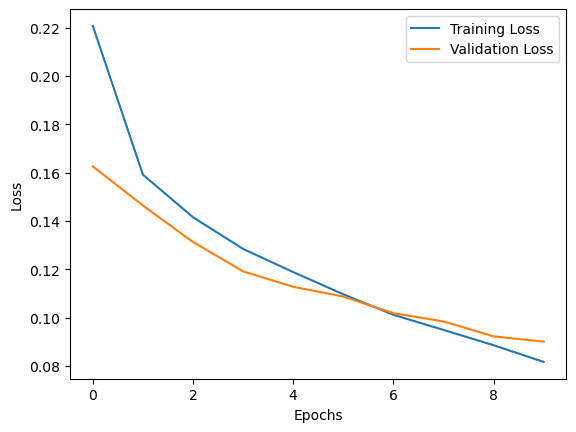

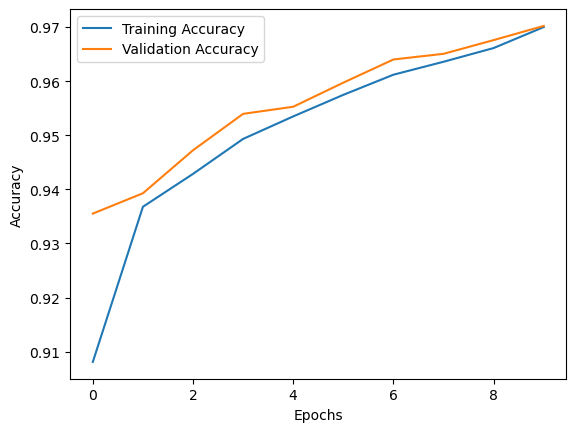

In [61]:
plot_loss_acc(history)

In [63]:
tfidf_w2v_model.save_weights("tfidf_w2v_model.h5")

# 3. TF-IDF weighted Word2vec vectors

## Machine learning models

In [64]:
sentence_vectors_tf = []

# Process each sentence and compute its vector
for i,sentence in enumerate(doc):
    tokens = word_tokenize(sentence.lower())
    sentence_vector = np.zeros(model_doc.vector_size)
    if len(tokens)==0:
         sentence_vectors_tf.append([0]*100)
    else:
        for token in tokens:
            if token in model_doc.wv:
                token_vector = model_doc.wv[token]
                sentence_vector += token_vector

        sentence_vector /= len(tokens)
        sentence_vector *= word_tfidf_weights[i]
        sentence_vectors_tf.append(sentence_vector)

# Convert the list of sentence vectors to a NumPy array
sentence_vectors_tf = np.array(sentence_vectors)
sentence_vectors_tf = np.nan_to_num(sentence_vectors_tf, nan=0.0)

In [73]:
sentence_vectors_tf.shape

(71537, 100)

In [77]:
pickle.dump(sentence_vectors_tf, open('features_w2v_tf_wts.pkl', 'wb'))

In [78]:
features_w2v_tf_wts=pickle.load( open('features_w2v_tf_wts.pkl', 'rb'))

In [80]:
train_ft,test_ft,train_labels,test_labels=split_data_ml(features_w2v_tf_wts,labels)

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


### Logistic Regression

              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      6816
        real       0.93      0.91      0.92      7492

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



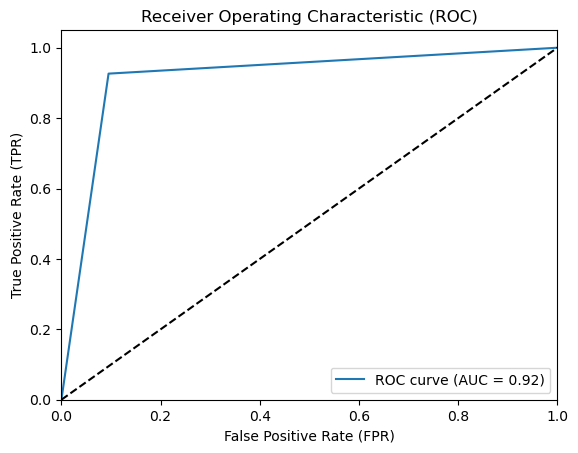

In [81]:
clf = LogisticRegression(random_state=0, max_iter=300).fit(train_ft, train_labels)
get_metrics(clf,test_ft,test_labels)
plot_ROC(test_labels)

### Linear Discriminant Analysis

              precision    recall  f1-score   support

        fake       0.88      0.92      0.90      6658
        real       0.93      0.89      0.91      7650

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308



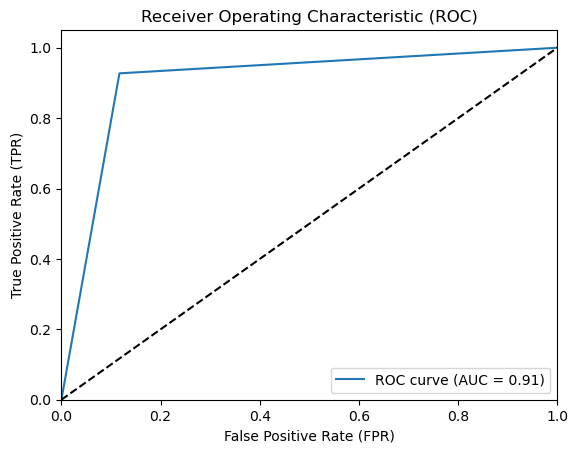

In [82]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)
get_metrics(clf,test_ft,test_labels)
plot_ROC(test_labels)

### Artificial Neural Networks

In [83]:
x_train,y_train,X_val,y_val,test_ft,test_labels=split_data_dl(features_w2v_tf_wts,labels)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [84]:
tfidf_w2v_wts_model= ANN_model()
tfidf_w2v_wts_model.build((None,115))
print(tfidf_w2v_model.summary())

Model: "ann_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  7424      
                                                                 
 dense_7 (Dense)             multiple                  2080      
                                                                 
 dense_8 (Dense)             multiple                  33        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
opt = keras.optimizers.SGD(learning_rate=0.1)
tfidf_w2v_wts_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=tfidf_w2v_wts_model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 7s 3ms/step - loss: 0.2162 - accuracy: 0.9123 - val_loss: 0.1794 - val_accuracy: 0.9275
Epoch 2/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1643 - accuracy: 0.9348 - val_loss: 0.1585 - val_accuracy: 0.9368
Epoch 3/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1486 - accuracy: 0.9409 - val_loss: 0.1460 - val_accuracy: 0.9416
Epoch 4/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1369 - accuracy: 0.9464 - val_loss: 0.1368 - val_accuracy: 0.9464
Epoch 5/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1271 - accuracy: 0.9498 - val_loss: 0.1314 - val_accuracy: 0.9469
Epoch 6/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1191 - accuracy: 0.9533 - val_loss: 0.1231 - val_accuracy: 0.9519
Epoch 7/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1123 - accuracy: 0.9565 - val_loss: 0.1176 - val_accuracy:

In [86]:
# Evaluate the model on the test set
test_loss, test_accuracy = tfidf_w2v_wts_model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9639
Test Loss: 0.09637467563152313, Test Accuracy: 0.9638663530349731


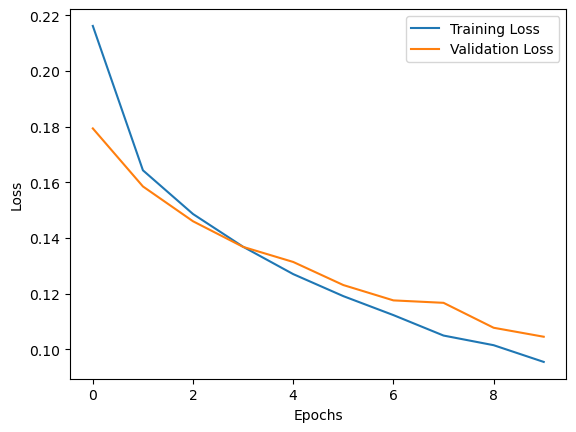

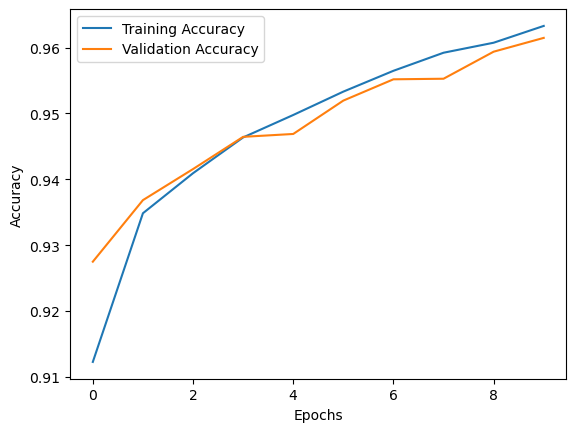

In [87]:
plot_loss_acc(history)

In [88]:
tfidf_w2v_wts_model.save_weights("tfidf_w2v_wts_model.h5")

# 4 TF-IDF weighted Word2vec with non numeric features

## Machine Learning Models

In [89]:
features_w2v_tfidf_txt = np.hstack((sentence_vectors_tf, non_text_features_np))

### Logistic Regression

In [90]:
train_ft,test_ft,train_labels,test_labels=split_data_ml(features_w2v_tfidf_txt,labels)

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      6809
        real       0.93      0.91      0.92      7499

    accuracy                           0.91     14308
   macro avg       0.91      0.92      0.91     14308
weighted avg       0.92      0.91      0.91     14308



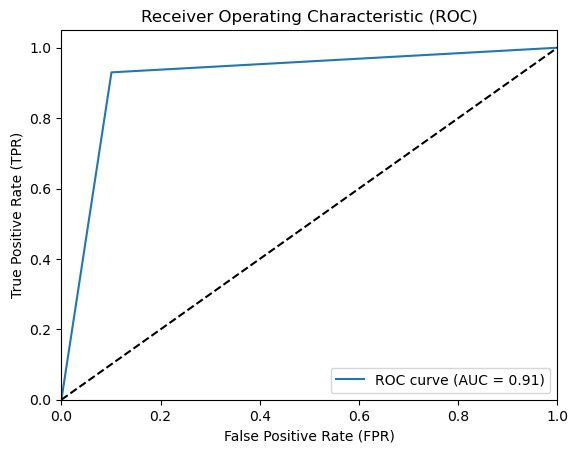

In [91]:
clf = LogisticRegression(random_state=0, max_iter=300).fit(train_ft, train_labels)
get_metrics(clf,test_ft,test_labels)
plot_ROC(test_labels)

### Linear Discriminant Analysis

              precision    recall  f1-score   support

        fake       0.88      0.93      0.90      6666
        real       0.93      0.89      0.91      7642

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308



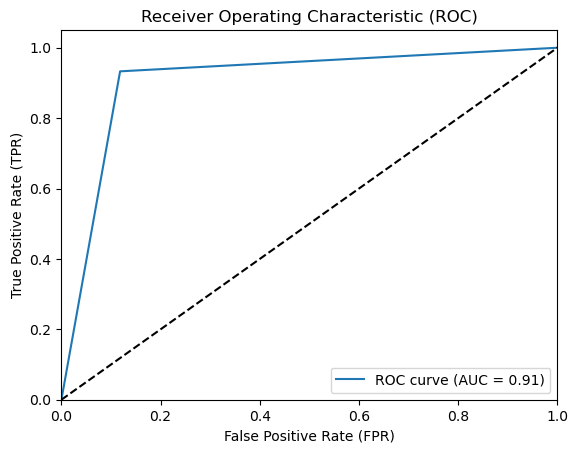

In [92]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)
get_metrics(clf,test_ft,test_labels)
plot_ROC(test_labels)

### Artificial Neural Networks

In [93]:
x_train,y_train,X_val,y_val,test_ft,test_labels=split_data_dl(features_w2v_tfidf_txt,labels)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [95]:
tfidf_w2v_txt_model= ANN_model()
tfidf_w2v_txt_model.build((None,115))
print(tfidf_w2v_txt_model.summary())

Model: "ann_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            multiple                  7424      
                                                                 
 dense_16 (Dense)            multiple                  2080      
                                                                 
 dense_17 (Dense)            multiple                  33        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
opt = keras.optimizers.SGD(learning_rate=0.1)
tfidf_w2v_txt_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=tfidf_w2v_txt_model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.2148 - accuracy: 0.9143 - val_loss: 0.1763 - val_accuracy: 0.9291
Epoch 2/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1650 - accuracy: 0.9348 - val_loss: 0.1527 - val_accuracy: 0.9404
Epoch 3/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1486 - accuracy: 0.9411 - val_loss: 0.1400 - val_accuracy: 0.9446
Epoch 4/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1369 - accuracy: 0.9463 - val_loss: 0.1325 - val_accuracy: 0.9483
Epoch 5/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1277 - accuracy: 0.9503 - val_loss: 0.1233 - val_accuracy: 0.9521
Epoch 6/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1203 - accuracy: 0.9530 - val_loss: 0.1231 - val_accuracy: 0.9518
Epoch 7/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1132 - accuracy: 0.9559 - val_loss: 0.1113 - val_accuracy:

In [97]:
# Evaluate the model on the test set
test_loss, test_accuracy = tfidf_w2v_txt_model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 2ms/step - loss: 0.1041 - accuracy: 0.9605
Test Loss: 0.10413851588964462, Test Accuracy: 0.9605116248130798


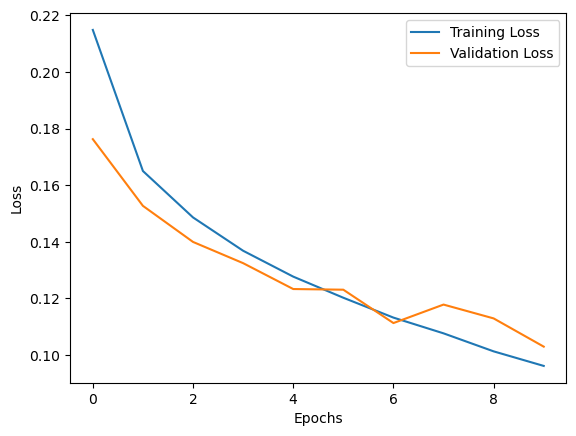

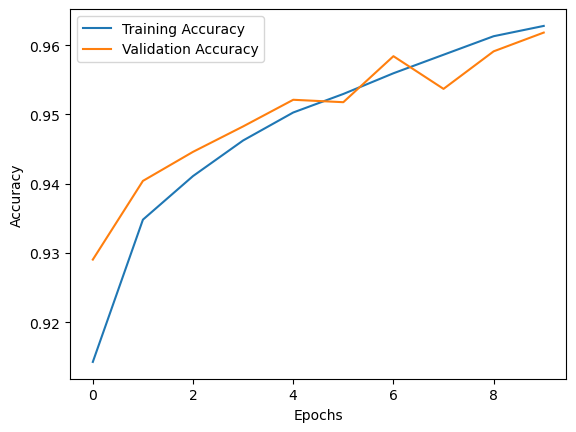

In [98]:
plot_loss_acc(history)

In [99]:
tfidf_w2v_txt_model.save_weights("tfidf_w2v_txt_model.h5")